In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(T=390, dt=1/390, S0=100, mu=0.0002, sigma=0.01):
    S = [S0]
    for _ in range(T):
        shock = np.random.normal()
        S_new = S[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * shock)
        S.append(S_new)
    return np.array(S)


In [2]:
def simulate_volatility(T, base_sigma=0.01):
    volatility = []
    sigma = base_sigma
    for t in range(T):
        if np.random.rand() < 0.02:  # 2% chance of volatility regime shift
            sigma *= np.random.uniform(0.5, 2.0)
            sigma = np.clip(sigma, 0.005, 0.05)
        volatility.append(sigma)
    return np.array(volatility)


In [3]:
def apply_shocks(price_series, shock_times, shock_magnitudes):
    for t, m in zip(shock_times, shock_magnitudes):
        price_series[t:] *= (1 + m)
    return price_series


In [4]:
def simulate_volume(volatility, base_vol=1e6, lambda_=30, noise_std=1e5):
    noise = np.random.normal(0, noise_std, size=len(volatility))
    volume = base_vol * (1 + lambda_ * volatility) + noise
    return np.maximum(volume, 0)


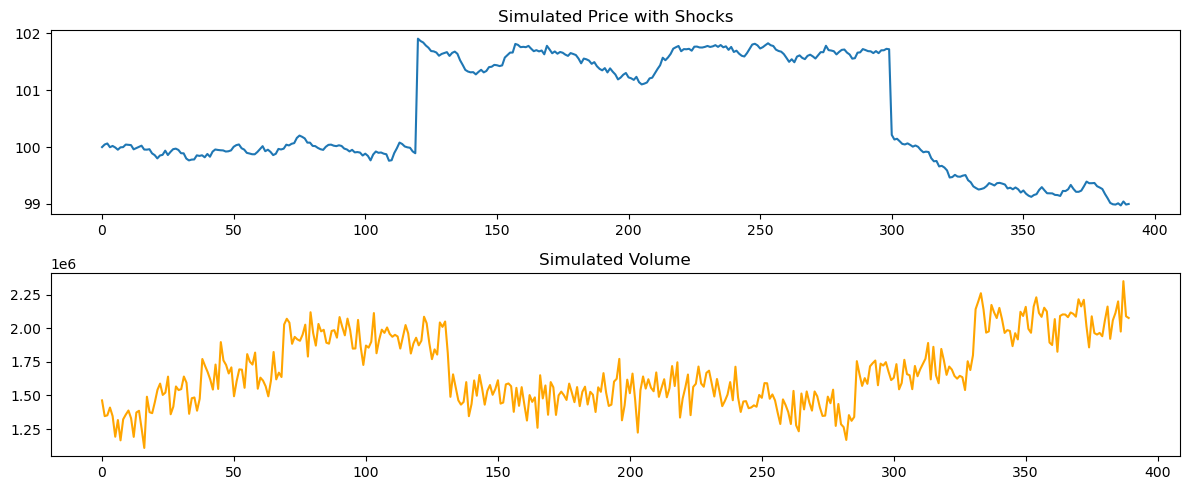

In [5]:
T = 390  # 1 trading day (minute-by-minute)
vols = simulate_volatility(T)
prices = simulate_gbm(T, sigma=0.01)
prices = apply_shocks(prices, shock_times=[120, 300], shock_magnitudes=[0.02, -0.015])
volume = simulate_volume(vols)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(prices, label="Price")
plt.title("Simulated Price with Shocks")
plt.subplot(2, 1, 2)
plt.plot(volume, label="Volume", color='orange')
plt.title("Simulated Volume")
plt.tight_layout()
plt.show()


In [6]:
class MarketMakingAgent:
    def __init__(self, name, base_spread=0.02):
        self.name = name
        self.spread = base_spread  # Fixed or adjustable later
        self.inventory = 0
        self.pnl = 0
        self.last_bid = None
        self.last_ask = None
        self.quote_history = []

    def quote(self, mid_price):
        """Generate bid/ask around the mid price."""
        bid = mid_price - self.spread / 2
        ask = mid_price + self.spread / 2
        self.last_bid = bid
        self.last_ask = ask
        self.quote_history.append((bid, ask))
        return bid, ask

    def execute_trade(self, price, quantity, side):
        """Update inventory and PnL."""
        if side == 'buy':  # market buy hits our ask
            self.inventory -= quantity
            self.pnl += price * quantity
        elif side == 'sell':  # market sell hits our bid
            self.inventory += quantity
            self.pnl -= price * quantity


In [7]:
def simulate_market(prices, volumes, agents):
    for t in range(1, len(prices)):
        mid = prices[t]
        vol = volumes[t]

        quotes = []
        for agent in agents:
            bid, ask = agent.quote(mid)
            quotes.append((agent, bid, ask))

        # Simulate one buyer and one seller randomly picking best available quotes
        best_bid = max(quotes, key=lambda x: x[1])
        best_ask = min(quotes, key=lambda x: x[2])

        # Simplified assumption: equal volume for both sides
        qty = vol / 1e6  # normalized
        best_bid[0].execute_trade(best_bid[1], qty, 'sell')
        best_ask[0].execute_trade(best_ask[2], qty, 'buy')


In [8]:
for agent in agents:
    print(f"{agent.name}: Final PnL = {agent.pnl:.2f}, Inventory = {agent.inventory}")


NameError: name 'agents' is not defined

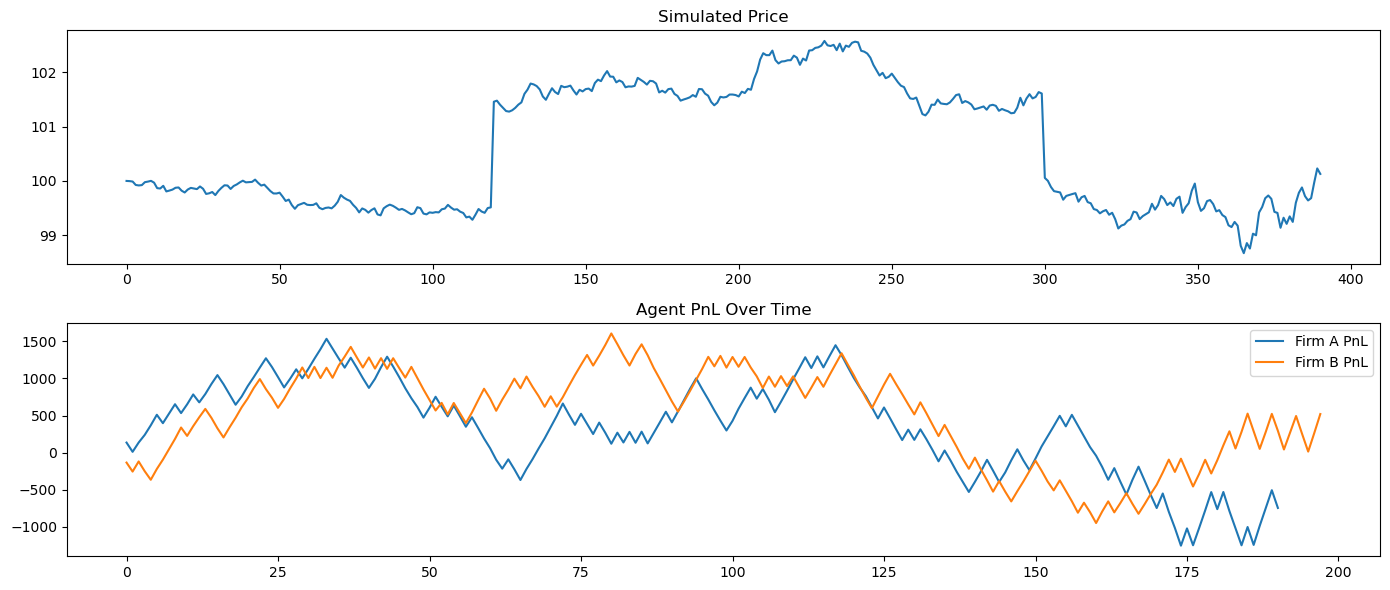

Firm A: Final PnL = -744.49, Inventory = 7.48
Firm B: Final PnL = 520.38, Inventory = -5.55


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Price Simulator ----------
def simulate_volatility(T, base_sigma=0.01):
    volatility = []
    sigma = base_sigma
    for t in range(T):
        if np.random.rand() < 0.02:  # regime shift
            sigma *= np.random.uniform(0.5, 2.0)
            sigma = np.clip(sigma, 0.005, 0.05)
        volatility.append(sigma)
    return np.array(volatility)

def simulate_gbm(T=390, dt=1/390, S0=100, mu=0.0002, volatility=None):
    S = [S0]
    for t in range(T):
        sigma = volatility[t]
        shock = np.random.normal()
        S_new = S[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * shock)
        S.append(S_new)
    return np.array(S)

def apply_shocks(price_series, shock_times, shock_magnitudes):
    for t, m in zip(shock_times, shock_magnitudes):
        price_series[t:] *= (1 + m)
    return price_series

def simulate_volume(volatility, base_vol=1e6, lambda_=30, noise_std=1e5):
    noise = np.random.normal(0, noise_std, size=len(volatility))
    volume = base_vol * (1 + lambda_ * volatility) + noise
    return np.maximum(volume, 0)

# ---------- Market Making Agent ----------
class MarketMakingAgent:
    def __init__(self, name, base_spread=0.02):
        self.name = name
        self.spread = base_spread
        self.inventory = 0
        self.pnl = 0
        self.last_bid = None
        self.last_ask = None
        self.quote_history = []
        self.pnl_history = []
        self.prev_mid = None
        self.pnl_window = []
        self.learning_rate = 0.05  # how fast we adapt


    def quote(self, mid_price, volatility):
        if self.prev_mid is None:
            self.prev_mid = mid_price
        price_change = mid_price - self.prev_mid
        self.prev_mid = mid_price

        dynamic_spread = self.spread * (1 + 5 * volatility + 0.01 * abs(self.inventory))
        signal_bias = 0.1 * price_change
        bias = 0.01 * self.inventory - signal_bias  # combine signal + inventory

        bid = mid_price - dynamic_spread / 2 - bias
        ask = mid_price + dynamic_spread / 2 - bias

        self.last_bid = bid
        self.last_ask = ask
        self.quote_history.append((bid, ask))
        return bid, ask


    def execute_trade(self, price, quantity, side):
        if side == 'buy':
            self.inventory -= quantity
            self.pnl += price * quantity
        elif side == 'sell':
            self.inventory += quantity
            self.pnl -= price * quantity
        self.pnl_history.append(self.pnl)


    def learn(self):
        self.pnl_window.append(self.pnl)
        if len(self.pnl_window) > 1:
            pnl_diff = self.pnl_window[-1] - self.pnl_window[-2]
            # Adjust spread: narrower if doing well, wider if losing
            if pnl_diff < 0:
                self.spread *= (1 + self.learning_rate)
            else:
                self.spread *= (1 - self.learning_rate)
            # Clamp spread to stay within bounds
            self.spread = np.clip(self.spread, 0.005, 0.05)


# ---------- Market Simulator ----------
def simulate_market(prices, volumes, agents, vols):
    for t in range(1, len(volumes)):
        mid = prices[t]
        vol = volumes[t]
        qty = vol / 1e6  # normalized execution size

        # Agents quote
        quotes = []
        for agent in agents:
            bid, ask = agent.quote(mid, vols[t])
            quotes.append((agent, bid, ask))

                # Simulated external market order
        side = np.random.choice(['buy', 'sell'])

        if side == 'buy':
            asks = np.array([q[2] for q in quotes])
            weights = np.exp(-asks + np.min(asks))  # lower ask = better
            probs = weights / weights.sum()
            chosen = np.random.choice(len(quotes), p=probs)
            agent, ask_price = quotes[chosen][0], quotes[chosen][2]
            agent.execute_trade(ask_price, qty, 'buy')

        else:
            bids = np.array([q[1] for q in quotes])
            weights = np.exp(bids - np.max(bids))  # higher bid = better
            probs = weights / weights.sum()
            chosen = np.random.choice(len(quotes), p=probs)
            agent, bid_price = quotes[chosen][0], quotes[chosen][1]
            agent.execute_trade(bid_price, qty, 'sell')


        # Optional: add inventory penalty to discourage runaway
        for agent in agents:
            penalty = 0.001 * (agent.inventory ** 2)
            agent.pnl -= penalty
            if agent.pnl_history:
                agent.pnl_history[-1] -= penalty # reflect in graph
        for agent in agents:
            agent.learn()

# ---------- Run Everything ----------
T = 390
vols = simulate_volatility(T)
prices = simulate_gbm(T, volatility=vols)
prices = apply_shocks(prices, [120, 300], [0.02, -0.015])
volume = simulate_volume(vols)

# Initialize agents
agent_A = MarketMakingAgent("Firm A", base_spread=0.02)
agent_B = MarketMakingAgent("Firm B", base_spread=0.025)
agents = [agent_A, agent_B]

simulate_market(prices, volume, agents, vols)

# ---------- Plot ----------
plt.figure(figsize=(14, 6))
plt.subplot(2,1,1)
plt.plot(prices, label="Price")
plt.title("Simulated Price")
plt.subplot(2,1,2)
plt.plot(agent_A.pnl_history, label="Firm A PnL")
plt.plot(agent_B.pnl_history, label="Firm B PnL")
plt.title("Agent PnL Over Time")
plt.legend()
plt.tight_layout()
plt.show()

for agent in agents:
    print(f"{agent.name}: Final PnL = {agent.pnl:.2f}, Inventory = {agent.inventory:.2f}")


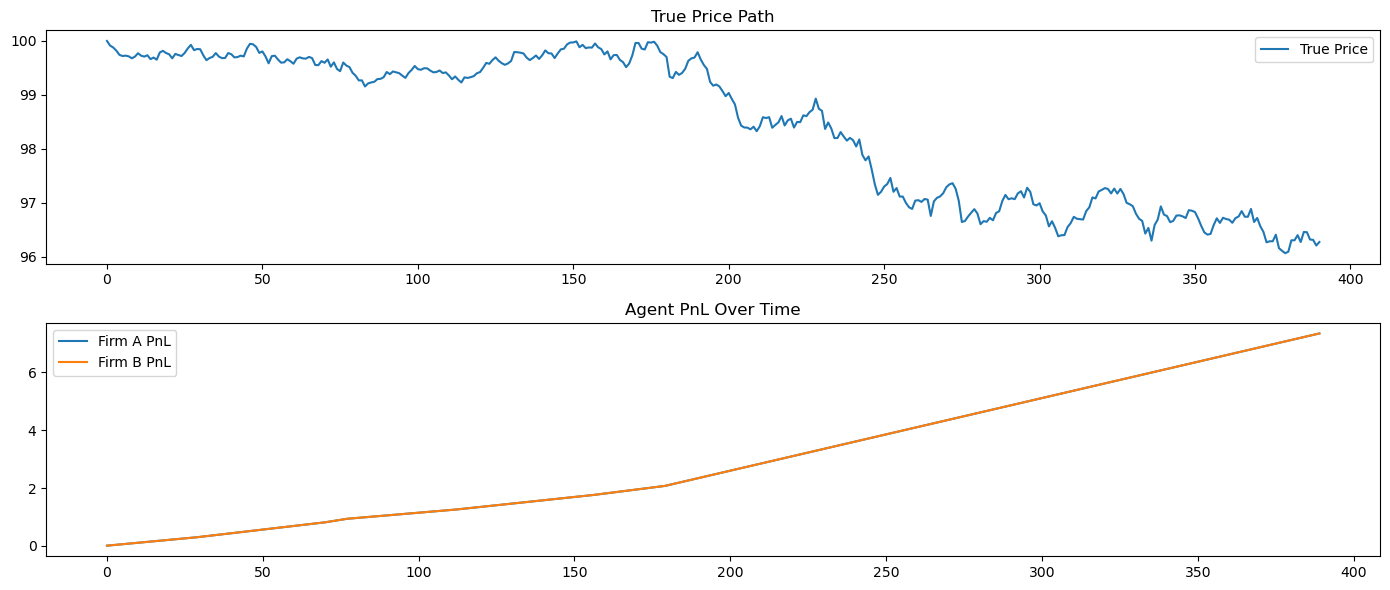

Firm A: Final PnL = 7.34
Firm B: Final PnL = 7.34


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Simulate Price and Volatility ----------
def simulate_volatility(T, base_sigma=0.01):
    volatility = []
    sigma = base_sigma
    for t in range(T):
        if np.random.rand() < 0.02:
            sigma *= np.random.uniform(0.5, 2.0)
            sigma = np.clip(sigma, 0.005, 0.05)
        volatility.append(sigma)
    return np.array(volatility)

def simulate_gbm(T=390, dt=1/390, S0=100, mu=0.0002, volatility=None):
    S = [S0]
    for t in range(T):
        sigma = volatility[t]
        shock = np.random.normal()
        S_new = S[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * shock)
        S.append(S_new)
    return np.array(S)

# ---------- 2. Agent Class ----------
class PredictiveAgent:
    def __init__(self, name, bias):
        self.name = name
        self.bias = bias  # [-1, 1]: -1 = aggressive, 0 = fair, 1 = conservative
        self.pnl_history = []
        self.pnl = 0

    def quote_price(self, expected_price, fuzziness):
        return expected_price + self.bias * fuzziness

    def update_pnl(self, true_price, quoted_price, quantity, side):
        if side == 'buy':
            self.pnl += (true_price - quoted_price) * quantity
        else:
            self.pnl += (quoted_price - true_price) * quantity
        self.pnl_history.append(self.pnl)

# ---------- 3. Simulation Function ----------
def simulate_market(T, true_prices, volatilities, agents, fuzziness_factor=2.0, quantity=1):
    for t in range(T):
        expected_price = true_prices[t]
        fuzziness = fuzziness_factor * volatilities[t]

        for i, agent in enumerate(agents):
            quote = agent.quote_price(expected_price, fuzziness)
            side = 'buy' if i % 2 == 0 else 'sell'  # alternate side each agent
            agent.update_pnl(true_prices[t], quote, quantity, side)

# ---------- 4. Run Simulation ----------
T = 390
vols = simulate_volatility(T)
true_prices = simulate_gbm(T, volatility=vols)

agent_A = PredictiveAgent("Firm A", bias=-0.5)  # aggressive
agent_B = PredictiveAgent("Firm B", bias=0.5)   # conservative
agents = [agent_A, agent_B]

simulate_market(T, true_prices[:-1], vols, agents)

# ---------- 5. Plot Results ----------
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(true_prices, label="True Price")
plt.title("True Price Path")
plt.legend()

plt.subplot(2, 1, 2)
for agent in agents:
    plt.plot(agent.pnl_history, label=f"{agent.name} PnL")
plt.title("Agent PnL Over Time")
plt.legend()
plt.tight_layout()
plt.show()
for agent in agents:
    print(f"{agent.name}: Final PnL = {agent.pnl:.2f}")
